<a href="https://colab.research.google.com/github/jtlai0921/-/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# dataset: https://github.com/cuilimeng/CrackForest-dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm.auto import tqdm

In [ ]:
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [57]:
# Download dataset
workspace_dir = '.'
# download from GoogleDrive
!gdown --id 1-DMkG6bs8Qt0UKnhbf4TmUqk_L4SvO5X --output "{workspace_dir}/data_seg.zip" # download from google drive
!unzip "{workspace_dir}/data_seg.zip"

Downloading...
From: https://drive.google.com/uc?id=1-DMkG6bs8Qt0UKnhbf4TmUqk_L4SvO5X
To: /content/data_seg.zip
9.06MB [00:00, 79.7MB/s]
Archive:  ./data_seg.zip
replace __MACOSX/._image? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._image        
  inflating: image/016.jpg           
  inflating: image/002.jpg           
  inflating: image/003.jpg           
  inflating: image/017.jpg           
  inflating: image/029.jpg           
  inflating: image/001.jpg           
  inflating: image/015.jpg           
  inflating: image/014.jpg           
  inflating: image/028.jpg           
  inflating: image/004.jpg           
  inflating: image/010.jpg           
  inflating: image/038.jpg           
  inflating: image/039.jpg           
  inflating: image/011.jpg           
  inflating: image/005.jpg           
  inflating: image/Icon              
  inflating: __MACOSX/image/._Icon   
  inflating: image/013.jpg           
  inflating: image/007.jpg           
  inflating:

In [58]:
IMG_SIZE = 256
SEED = 5566
FOLDER_PATH = '.'
# FOLDER_PATH = '/content/drive/My Drive/class/緯育AI瑕疵檢測/Day4/crack-seg'

In [59]:
img_folder = os.path.join(FOLDER_PATH, 'image/*.jpg')
mask_folder = os.path.join(FOLDER_PATH, 'mask/*.png')
img_paths = sorted(glob(img_folder)) #[:10] # demo for 10 images only
mask_paths = sorted(glob(mask_folder)) #[:10] # demo for 10 images only

In [60]:
len(img_paths), len(mask_paths)

(118, 118)

In [61]:
x_data = np.empty((len(img_paths), IMG_SIZE, IMG_SIZE, 3))
y_data = np.empty((len(img_paths), IMG_SIZE, IMG_SIZE))

# img
for i, path in tqdm(enumerate(img_paths)):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.
    x_data[i] = img

# mask
for i, path in tqdm(enumerate(mask_paths)):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img[img > 0] = 1
    y_data[i] = img
y_data = np.expand_dims(y_data, axis=-1) # (# of images, IMG_SIZE, IMG_SIZE) -> (# of images, IMG_SIZE, IMG_SIZE, 1)

In [62]:
# pixel value
np.unique(y_data[0], return_counts=True)

(array([0., 1.]), array([64462,  1074]))

In [63]:
x_data.shape, y_data.shape

((118, 256, 256, 3), (118, 256, 256, 1))

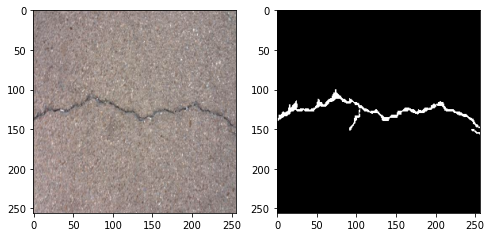

./image/109.jpg ./mask/109.png


In [64]:
# sample image
random_idx = np.random.randint(0, high=len(img_paths))
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[random_idx], cmap='gray')
ax[1].imshow(y_data[random_idx,:,:,0], cmap='gray')
plt.show()
print(img_paths[random_idx], mask_paths[random_idx])

In [65]:
# spilit train and test
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.1, random_state=5566)

In [66]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((106, 256, 256, 3), (12, 256, 256, 3), (106, 256, 256, 1), (12, 256, 256, 1))

# Model

In [68]:
# Unet witn Upsampling
input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [69]:
# Unet with Conv2DTranspose
activation = 'relu'
input_layer = Input(shape=x_train.shape[1:])
l = Conv2D(filters=8, kernel_size=(3,3), activation=activation, padding='same')(input_layer)
c1 = Conv2D(filters=8, kernel_size=(3,3), activation=activation, padding='same')(l)
l = MaxPool2D(strides=(2,2))(c1)
l = Conv2D(filters=16, kernel_size=(3,3), activation=activation, padding='same')(l)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation=activation, padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
l = Conv2D(filters=32, kernel_size=(3,3), activation=activation, padding='same')(l)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation=activation, padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
l = Conv2D(filters=32, kernel_size=(3,3), activation=activation, padding='same')(l)
c4 = Conv2D(filters=32, kernel_size=(3,3), activation=activation, padding='same')(l)
l = concatenate([Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(3,3), activation=activation, padding='same')(l)
l = Conv2D(filters=32, kernel_size=(3,3), activation=activation, padding='same')(l)
l = concatenate([Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(l), c2], axis=-1)
l = Conv2D(filters=64, kernel_size=(3,3), activation=activation, padding='same')(l)
l = Conv2D(filters=64, kernel_size=(3,3), activation=activation, padding='same')(l)
l = concatenate([Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(l), c1], axis=-1)
l = Conv2D(filters=64, kernel_size=(3,3), activation=activation, padding='same')(l)
l = Conv2D(filters=64, kernel_size=(3,3), activation=activation, padding='same')(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

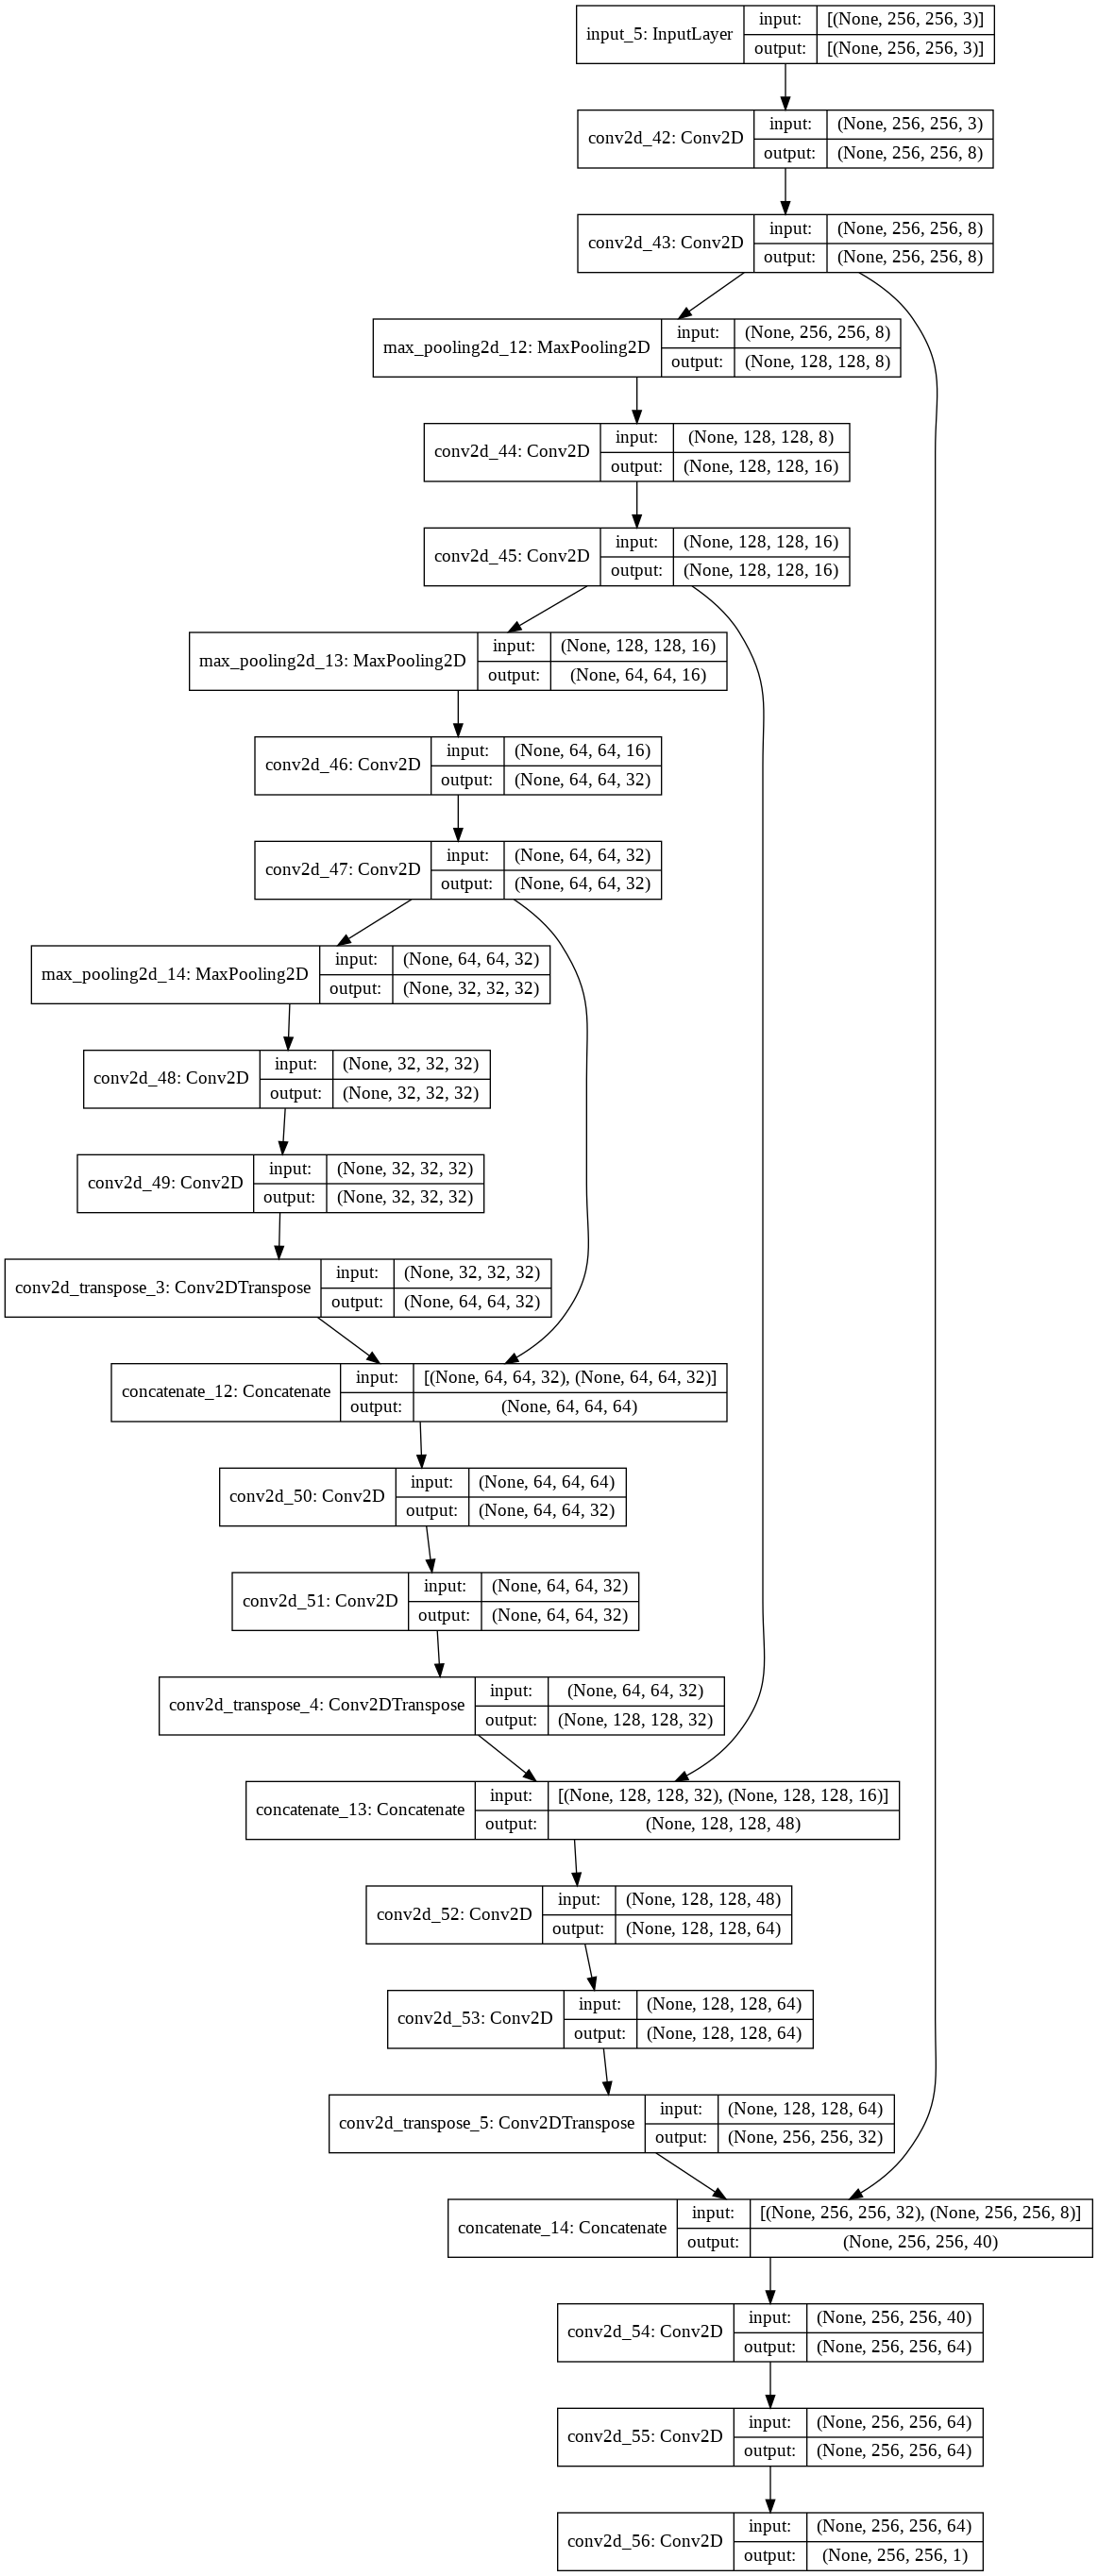

In [70]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [71]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 256, 256, 8)  224         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 256, 256, 8)  584         conv2d_42[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_43[0][0]                  
____________________________________________________________________________________________

# Data Augmentation

In [72]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            horizontal_flip=True,
            vertical_flip=True,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rotation_range=90,
            fill_mode='reflect',
            zoom_range=0.2).flow(x_train, y_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            horizontal_flip=True,
            vertical_flip=True,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rotation_range=90,
            fill_mode='reflect',
            zoom_range=0.2).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

In [73]:
BATCH_SIZE = 4
gen = my_generator(x_train, y_train, BATCH_SIZE)

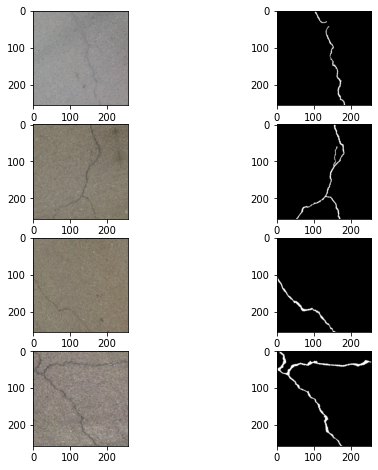

In [74]:
image_batch, mask_batch = next(gen)
fix, ax = plt.subplots(BATCH_SIZE, 2, figsize=(8,8))
for i in range(BATCH_SIZE):
    ax[i,0].imshow(image_batch[i,::])
    ax[i,1].imshow(mask_batch[i,:,:,0], cmap=plt.cm.gray)
plt.show()

# Training

In [75]:
# customized Dice coefficient
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
    
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[dice_coef])

In [76]:
# Callbacks
weight_saver = ModelCheckpoint('seg.h5', monitor='val_loss', save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=10)
rle = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5)

In [77]:
data_gen = my_generator(x_train, y_train, BATCH_SIZE)

logs = model.fit(data_gen,
                 steps_per_epoch = x_train.shape[0] // BATCH_SIZE,
                 validation_data = (x_val, y_val),
                 epochs=100, verbose=1,
                 callbacks = [weight_saver])

# hist = model.fit_generator(data_gen,
#                            steps_per_epoch = x_train.shape[0] // BATCH_SIZE,
#                            validation_data = (x_val, y_val),
#                            epochs=100, verbose=1,
#                            callbacks = [weight_saver])

Epoch 1/100
26/26 [==============================] - 4s 105ms/step - loss: 0.3487 - dice_coef: 0.0394 - val_loss: 0.2348 - val_dice_coef: 0.0205
Epoch 2/100
26/26 [==============================] - 2s 93ms/step - loss: 0.1147 - dice_coef: 0.0293 - val_loss: 0.2059 - val_dice_coef: 0.0526
Epoch 3/100
26/26 [==============================] - 2s 90ms/step - loss: 0.1182 - dice_coef: 0.0266 - val_loss: 0.2032 - val_dice_coef: 0.0452
Epoch 4/100
26/26 [==============================] - 2s 90ms/step - loss: 0.1505 - dice_coef: 0.0434 - val_loss: 0.2340 - val_dice_coef: 0.0211
Epoch 5/100
26/26 [==============================] - 2s 90ms/step - loss: 0.1173 - dice_coef: 0.0332 - val_loss: 0.2284 - val_dice_coef: 0.0234
Epoch 6/100
26/26 [==============================] - 2s 89ms/step - loss: 0.1102 - dice_coef: 0.0302 - val_loss: 0.2315 - val_dice_coef: 0.0221
Epoch 7/100
26/26 [==============================] - 2s 90ms/step - loss: 0.1110 - dice_coef: 0.0315 - val_loss: 0.1982 - val_dice_coef

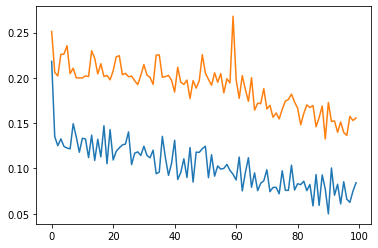

In [53]:
logs = logs.history
plt.plot(logs['loss'])
plt.plot(logs['val_loss'])
plt.show()

# Results

In [54]:
# load pre-trained model
model2 = load_model(os.path.join(FOLDER_PATH, 'seg.h5'), compile=False)
# model2 = load_model('/content/drive/MyDrive/class/緯育AI瑕疵檢測/Day4/crack-seg/seg.h5', compile=False)

In [55]:
# predict first 4 images
y_pred = model2.predict(x_val[:4])

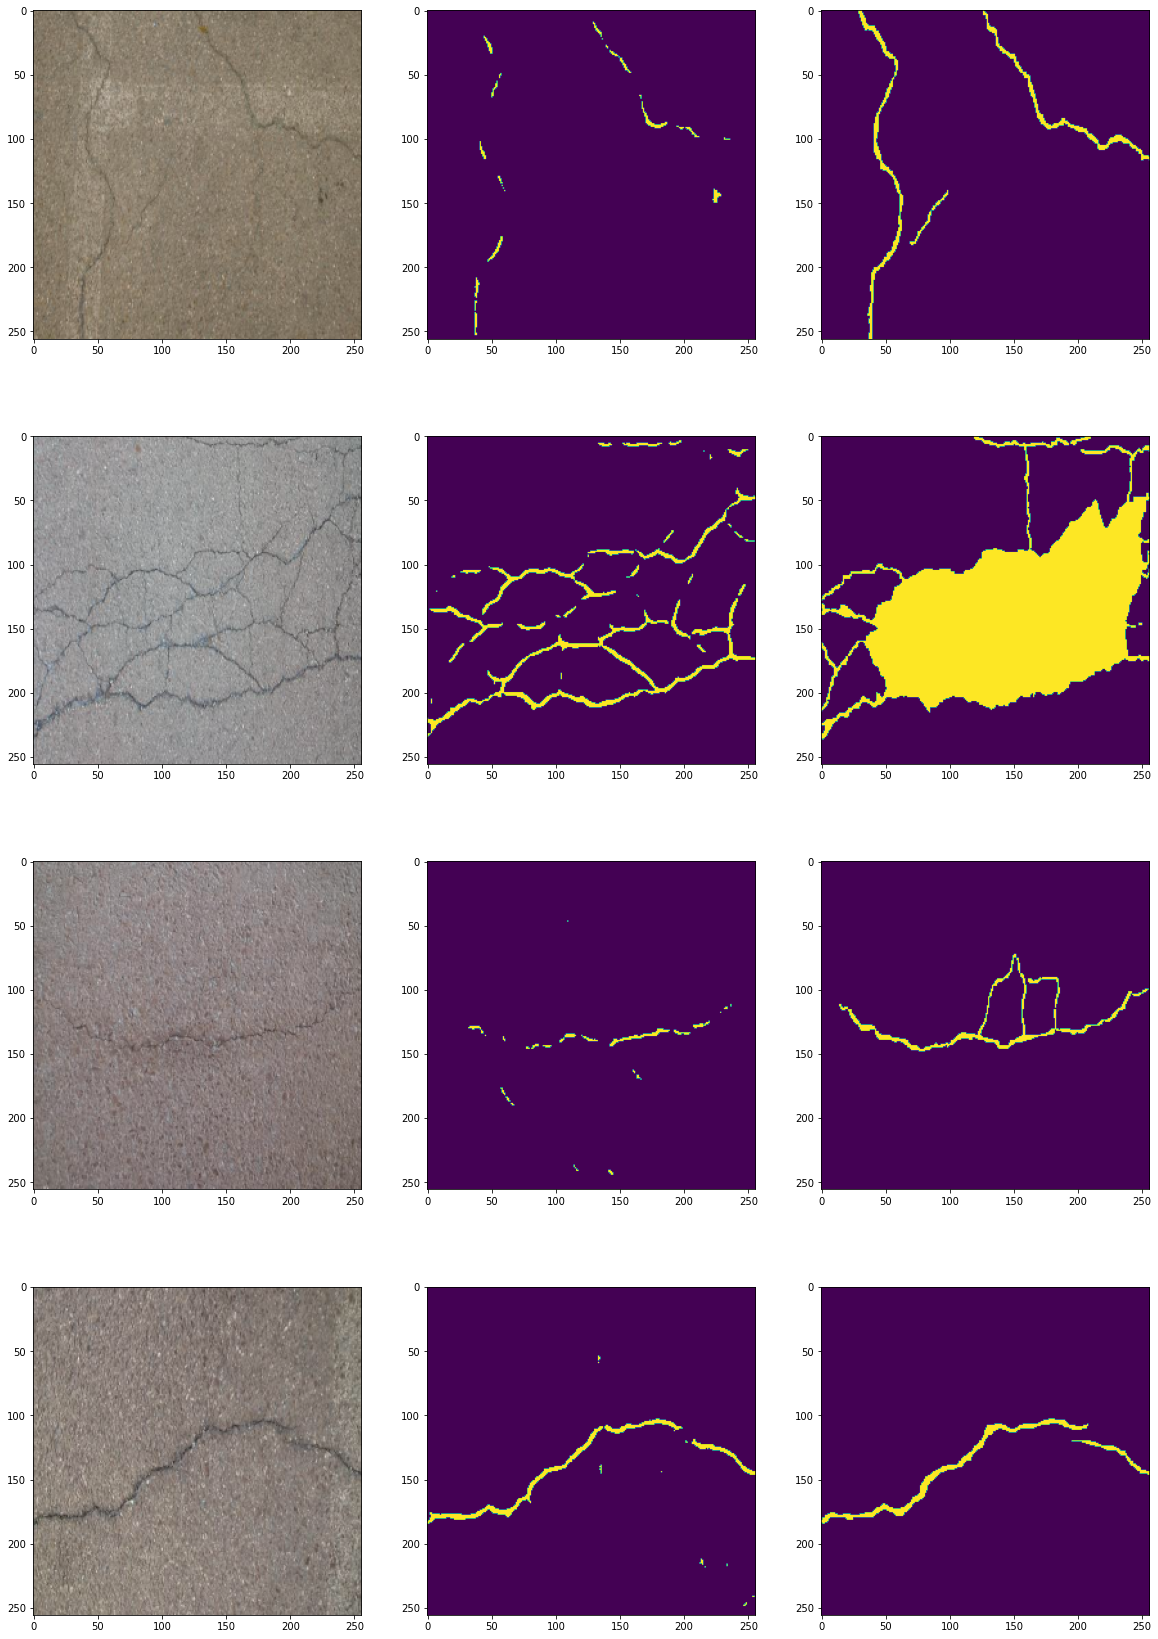

In [56]:
# Results

fix, ax = plt.subplots(4, 3, figsize=(20,30))
threshold = 0.5
for i in range(4):
    
    ax[i,0].imshow(x_val[i])
    pred = y_pred[i, :, :, 0]
    pred[pred>threshold] = 1
    pred[pred<=threshold] = 0
    ax[i,1].imshow(pred)
    ax[i,2].imshow(y_val[i, :, :, 0])
plt.show()